# Langzeit Scheduling

In [1]:
import json
import pandas as pd
import numpy as np
import random

In [23]:
import pulp

In [2]:
import utils.schedule_interarrival as sit

In [3]:
import utils.presenter as show
import utils.schedule_solver as ssv

In [4]:
from utils.checker import is_machine_conflict_free
from utils.checker import is_job_machine_sequence_correct
from utils.checker import is_start_correct

In [5]:
# Datei laden
with open("data/jobshop_instances.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
show.print_jobs(instance)

job 0:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
job 1:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
job 2:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
job 3:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
job 4:  [[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
job 5:  [[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
job 6:  [[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
job 7:  [[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
job 8:  [[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
job 9:  [[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]



In [8]:
def add_jobs_to_dict(job_set_dict, new_instance, shuffle=False, seed=50):
    offset = len(job_set_dict)
    items = list(new_instance.items())

    if shuffle:
        random.seed(seed)
        random.shuffle(items)

    for i, (_, ops) in enumerate(items):
        job_name = f"Job_{offset + i:03d}"
        job_set_dict[job_name] = ops

In [9]:
jssp_data = {}

days = 2
for i in range(int(2.3 *days)):
    shuffle = False if (i % 4 == 0) else True
    add_jobs_to_dict(jssp_data, instance, shuffle)
    
mean_interarrival_time = sit.calculate_mean_interarrival_time(jssp_data)
df_arrivals = sit.generate_job_arrivals_df_by_mean_interarrival_time(jssp_data, t_a=mean_interarrival_time)


# Schritt 1: Filter auf df_arrivals anwenden (wie du bereits gemacht hast)

df_arrivals = df_arrivals[df_arrivals["Ankunftszeit (Minuten)"] <= (60 * 24 * days)]
df_arrivals

,Job-ID,Ankunftszeit (Minuten)
0,Job_000,0.00
1,Job_001,84.93
2,Job_002,106.18
3,Job_003,148.31
4,Job_004,185.08
5,Job_005,251.37
6,Job_006,312.71
7,Job_007,329.63
8,Job_008,344.30
9,Job_009,429.20


In [14]:
# Schritt 2: Nur die verbleibenden Job-IDs extrahieren
valid_job_ids = set(df_arrivals["Job-ID"])

# Schritt 3: jssp_data kürzen
jssp_data = {job_id: ops for job_id, ops in jssp_data.items() if job_id in valid_job_ids}
show.print_jobs(jssp_data)

Job_000:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job_001:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job_002:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job_003:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job_004:  [[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job_005:  [[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job_006:  [[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job_007:  [[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job_008:  [[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job_009:  [[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 4

In [10]:
#df_schedule_plan, makespan = ssv.solve_jssp_global_makespan(jssp_data, df_arrivals, solver_time_limit=420)
#df_schedule_plan

In [11]:
#category = "1 Tage"

#show.plot_gantt_jobs(df_schedule_plan, 'Gantt-Diagramm für "{}"'.format(category))
#show.plot_gantt_machines(df_schedule_plan, 'Gantt-Diagramm für "{}"'.format(category))

In [36]:
import pulp
import pandas as pd

def solve_jssp_total_individual_makespans(job_dict, df_arrivals, solver_time_limit=300, epsilon=0.00):
    """
    Minimiert die Summe der individuellen Makespans (Durchlaufzeiten) aller Jobs:
    Makespan_j = Endzeit_j - Ankunftszeit_j

    Parameter:
    - job_dict: Dictionary mit Jobdaten (jede Operation als (Maschine, Dauer))
    - df_arrivals: DataFrame mit Spalten "Job-ID" und "Ankunftszeit (Minuten)"
    - solver_time_limit: Max. Zeit in Sekunden für den Solver
    - epsilon: Kleiner Abstand zur Vermeidung von Maschinenkonflikten
    """

    # Ankunftszeiten als Dictionary
    arrival_times = df_arrivals.set_index("Job-ID")["Ankunftszeit (Minuten)"].to_dict()

    # Jobnamen nach Ankunftszeit sortieren
    job_names = sorted(job_dict.keys(), key=lambda j: arrival_times[j])
    num_jobs = len(job_names)

    # Operationen in gleicher Reihenfolge wie job_names
    all_ops = [job_dict[job] for job in job_names]

    # Maschinenmenge extrahieren
    all_machines = {op[0] for job in all_ops for op in job}

    # LP-Problem definieren
    prob = pulp.LpProblem("JobShop_Minimize_Total_Individual_Makespans", pulp.LpMinimize)

    # Startzeit-Variablen für jede Operation
    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0, cat="Continuous")
        for j in range(num_jobs) for o in range(len(all_ops[j]))
    }

    # Endzeit-Variable pro Job (letzte Operation)
    job_ends = {
        j: pulp.LpVariable(f"job_end_{j}", lowBound=0, cat="Continuous")
        for j in range(num_jobs)
    }

    # Ziel: Summe der Durchlaufzeiten (Ende - Ankunft) minimieren
    prob += pulp.lpSum([
        job_ends[j] - arrival_times[job_names[j]]
        for j in range(num_jobs)
    ])

    # Technologische Reihenfolge + Ankunftszeit
    for j, job_name in enumerate(job_names):
        job = job_dict[job_name]
        prob += starts[(j, 0)] >= arrival_times[job_name]
        for o in range(1, len(job)):
            d_prev = job[o - 1][1]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev

    # Maschinenkonflikte (Disjunktivität mit big-M)
    bigM = 1e5
    for m in all_machines:
        ops = [(j, o, d) for j in range(num_jobs)
               for o, (mach, d) in enumerate(all_ops[j]) if mach == m]
        for i in range(len(ops)):
            j1, o1, d1 = ops[i]
            for j2, o2, d2 in ops[i + 1:]:
                if j1 != j2:
                    y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                    prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                    prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # Endzeit pro Job definieren (letzte Operation)
    for j in range(num_jobs):
        last_op = len(all_ops[j]) - 1
        prob += job_ends[j] >= starts[(j, last_op)] + all_ops[j][last_op][1]

    # Solver ausführen
    solver = pulp.HiGHS_CMD(msg=True, timeLimit=solver_time_limit)
    prob.solve(solver)

    # Ergebnis extrahieren
    schedule_data = []
    for (j, o), var in sorted(starts.items()):
        start = var.varValue
        if start is not None:
            machine, duration = all_ops[j][o]
            end = start + duration
            schedule_data.append({
                "Job": job_names[j],
                "Machine": f"M{machine}",
                "Start": round(start, 2),
                "Processing Time": duration,
                "End": round(end, 2)
            })

    df_schedule = pd.DataFrame(schedule_data)

    # Nur letzte Operation pro Job → Flow time berechnen
    df_schedule["Arrival"] = df_schedule["Job"].map(arrival_times)
    df_schedule["IsLastOp"] = df_schedule.groupby("Job")["End"].transform("max") == df_schedule["End"]
    df_schedule["Flow time"] = df_schedule.apply(
        lambda row: row["End"] - row["Arrival"] if row["IsLastOp"] else None,
        axis=1
    )
    df_schedule.drop(columns=["IsLastOp"], inplace=True)

    # Spaltenreihenfolge anpassen
    df_schedule = df_schedule[["Job", "Arrival", "Machine", "Start", "Processing Time", "Flow time", "End"]]

    # Gesamtdurchlaufzeit (Zielfunktion)
    total_makespan = round(pulp.value(prob.objective), 3)

    return df_schedule, total_makespan


In [38]:
df_plan, total = solve_jssp_total_individual_makespans(jssp_data, df_arrivals, solver_time_limit=300, epsilon=0.06)

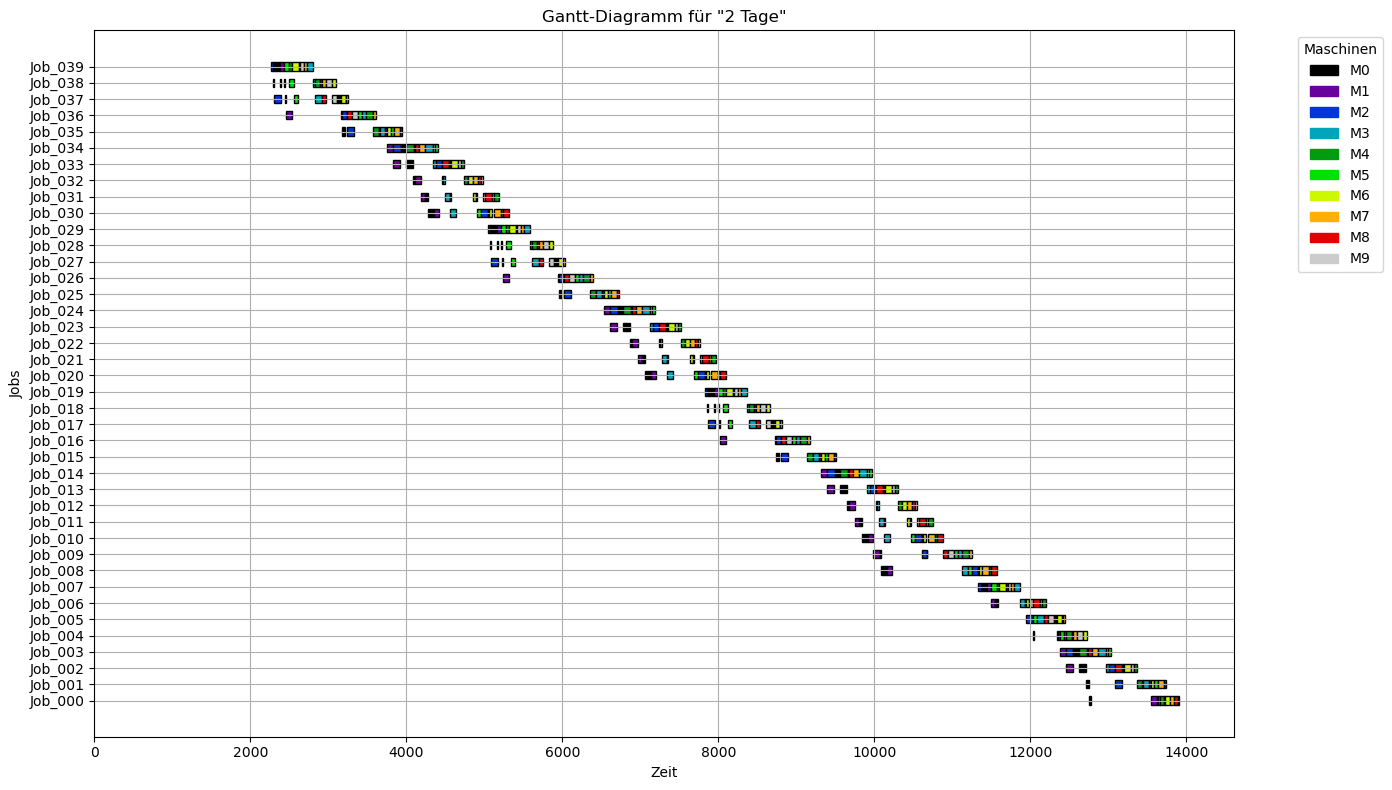

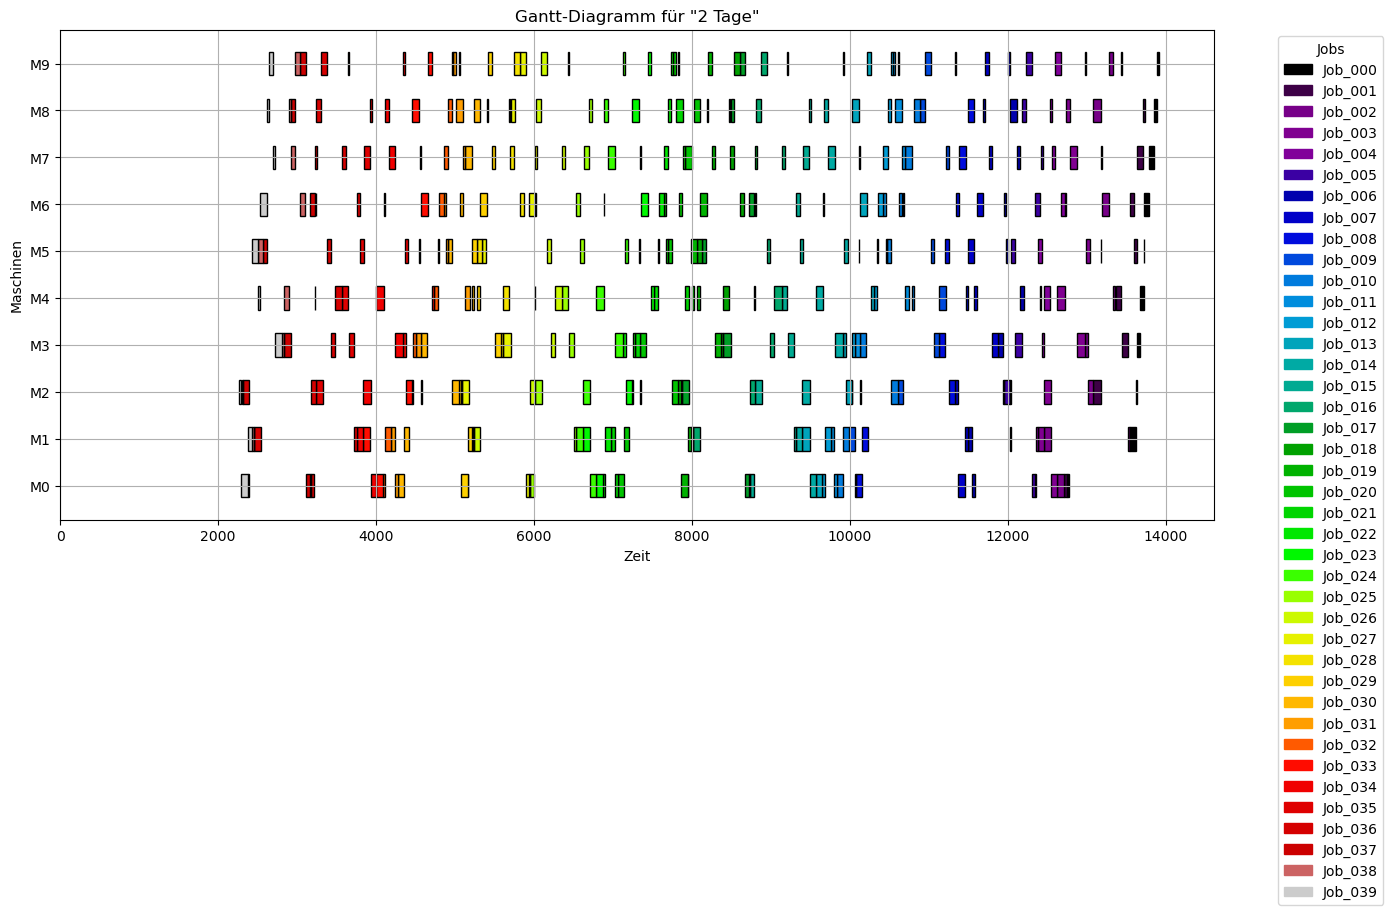

True

In [40]:
category = "2 Tage"

show.plot_gantt_jobs(df_plan, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")
show.plot_gantt_machines(df_plan, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")

is_machine_conflict_free(df_plan)
is_job_machine_sequence_correct(df_plan, jssp_data)
is_start_correct(df_plan, df_arrivals)

In [26]:
df_plan[df_plan.Job == "Job_000"]

,Job,Arrival,Machine,Start,Processing Time,Flow time,End
0,Job_000,0.0,M0,12749.28,29,12778.28,12778.28
1,Job_000,0.0,M1,13544.28,78,13622.28,13622.28
2,Job_000,0.0,M2,13622.28,9,13631.28,13631.28
3,Job_000,0.0,M3,13631.28,36,13667.28,13667.28
4,Job_000,0.0,M4,13667.28,49,13716.28,13716.28
5,Job_000,0.0,M5,13716.28,11,13727.28,13727.28
6,Job_000,0.0,M6,13727.28,62,13789.28,13789.28
7,Job_000,0.0,M7,13789.28,56,13845.28,13845.28
8,Job_000,0.0,M8,13845.28,44,13889.28,13889.28
9,Job_000,0.0,M9,13889.28,21,13910.28,13910.28


In [20]:
max(df_plan.End)

13910.28

In [18]:
df_job_flow = (
    df_plan.loc[df_plan.groupby("Job")["End"].idxmax()][["Job", "Arrival", "Flow time", "End"]]
    .rename(columns={"Arrival": "Arrival Time", "End": "Completion Time"})
    .reset_index(drop=True)
)
df_job_flow.

,Job,Arrival Time,Flow time,Completion Time
0,Job_000,0.00,13910.28,13910.28
1,Job_001,84.93,13653.29,13738.22
2,Job_002,106.18,13254.98,13361.16
3,Job_003,148.31,12885.79,13034.10
4,Job_004,185.08,12539.96,12725.04
5,Job_005,251.37,12190.61,12441.98
6,Job_006,312.71,11892.21,12204.92
7,Job_007,329.63,11542.23,11871.86
8,Job_008,344.30,11228.50,11572.80
9,Job_009,429.20,10826.54,11255.74


In [ ]:
df_plan.to_csv("data/03_schedule_two_days.csv", index = False)

#### Gewichtet wenn früher gestartet

In [37]:
def solve_jssp_weighted_total_flowtime(job_dict, df_arrivals, solver_time_limit=300, epsilon=0.00):
    """
    Minimiert die gewichtete Summe der individuellen Durchlaufzeiten (Flow Times) aller Jobs.
    Gewichtung bevorzugt früh ankommende Jobs.

    Gewicht_j = 1 / (1 + Ankunftszeit_j)
    Zielfunktion: sum_j [ Gewicht_j * (Endzeit_j - Ankunftszeit_j) ]

    Parameter:
    - job_dict: Dictionary mit Jobdaten (jede Operation als (Maschine, Dauer))
    - df_arrivals: DataFrame mit Spalten "Job-ID" und "Ankunftszeit (Minuten)"
    - solver_time_limit: Max. Zeit in Sekunden für den Solver
    - epsilon: Kleiner Abstand zur Vermeidung von Maschinenkonflikten
    """

    # Ankunftszeiten als Dictionary
    df_arrivals = df_arrivals.sort_values("Ankunftszeit (Minuten)").reset_index(drop=True)
    arrival_times = df_arrivals.set_index("Job-ID")["Ankunftszeit (Minuten)"].to_dict()
    job_names = list(df_arrivals.sort_values("Ankunftszeit (Minuten)", ascending=False)["Job-ID"])


    num_jobs = len(job_names)

    # Operationen in Ankunftsreihenfolge
    all_ops = [job_dict[job] for job in job_names]

    # Maschinen extrahieren
    all_machines = {op[0] for job in all_ops for op in job}

    # LP-Problem
    prob = pulp.LpProblem("JobShop_Weighted_Total_FlowTime", pulp.LpMinimize)

    # Startzeitvariablen
    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0, cat="Continuous")
        for j in range(num_jobs) for o in range(len(all_ops[j]))
    }

    # Endzeitvariablen je Job
    job_ends = {
        j: pulp.LpVariable(f"job_end_{j}", lowBound=0, cat="Continuous")
        for j in range(num_jobs)
    }

    # Gewichtung: frühere Ankunft = höhere Priorität
    weights = {j: 1 / (1 + arrival_times[job_names[j]]) for j in range(num_jobs)}

    # Zielfunktion: gewichtete Durchlaufzeiten minimieren
    prob += pulp.lpSum([
        weights[j] * (job_ends[j] - arrival_times[job_names[j]])
        for j in range(num_jobs)
    ])

    # Technologische Reihenfolge + Ankunft
    for j, job_name in enumerate(job_names):
        job = job_dict[job_name]
        prob += starts[(j, 0)] >= arrival_times[job_name]
        for o in range(1, len(job)):
            d_prev = job[o - 1][1]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev

    # Maschinenkonflikte
    bigM = 1e5
    for m in all_machines:
        ops = [(j, o, d) for j in range(num_jobs)
               for o, (mach, d) in enumerate(all_ops[j]) if mach == m]
        for i in range(len(ops)):
            j1, o1, d1 = ops[i]
            for j2, o2, d2 in ops[i + 1:]:
                if j1 != j2:
                    y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                    prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                    prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # Endzeit je Job = Ende letzter Operation
    for j in range(num_jobs):
        last_op = len(all_ops[j]) - 1
        prob += job_ends[j] >= starts[(j, last_op)] + all_ops[j][last_op][1]

    # Solver
    solver = pulp.HiGHS_CMD(msg=True, timeLimit=solver_time_limit)
    prob.solve(solver)

    # Ergebnisse extrahieren
    schedule_data = []
    for (j, o), var in sorted(starts.items()):
        start = var.varValue
        if start is not None:
            machine, duration = all_ops[j][o]
            end = start + duration
            schedule_data.append({
                "Job": job_names[j],
                "Machine": f"M{machine}",
                "Start": round(start, 2),
                "Processing Time": duration,
                "End": round(end, 2)
            })

    df_schedule = pd.DataFrame(schedule_data)

    df_schedule["Arrival"] = df_schedule["Job"].map(arrival_times)
    df_schedule["Flow time"] = df_schedule["End"] - df_schedule["Arrival"]

    df_schedule = df_schedule[["Job", "Arrival", "Machine", "Start", "Processing Time", "Flow time", "End"]]

    # Gesamtzielwert
    total_weighted_flowtime = round(pulp.value(prob.objective), 3)

    return df_schedule, total_weighted_flowtime


In [39]:
df_plan, total = solve_jssp_weighted_total_flowtime(jssp_data, df_arrivals, solver_time_limit=300, epsilon=0.06)

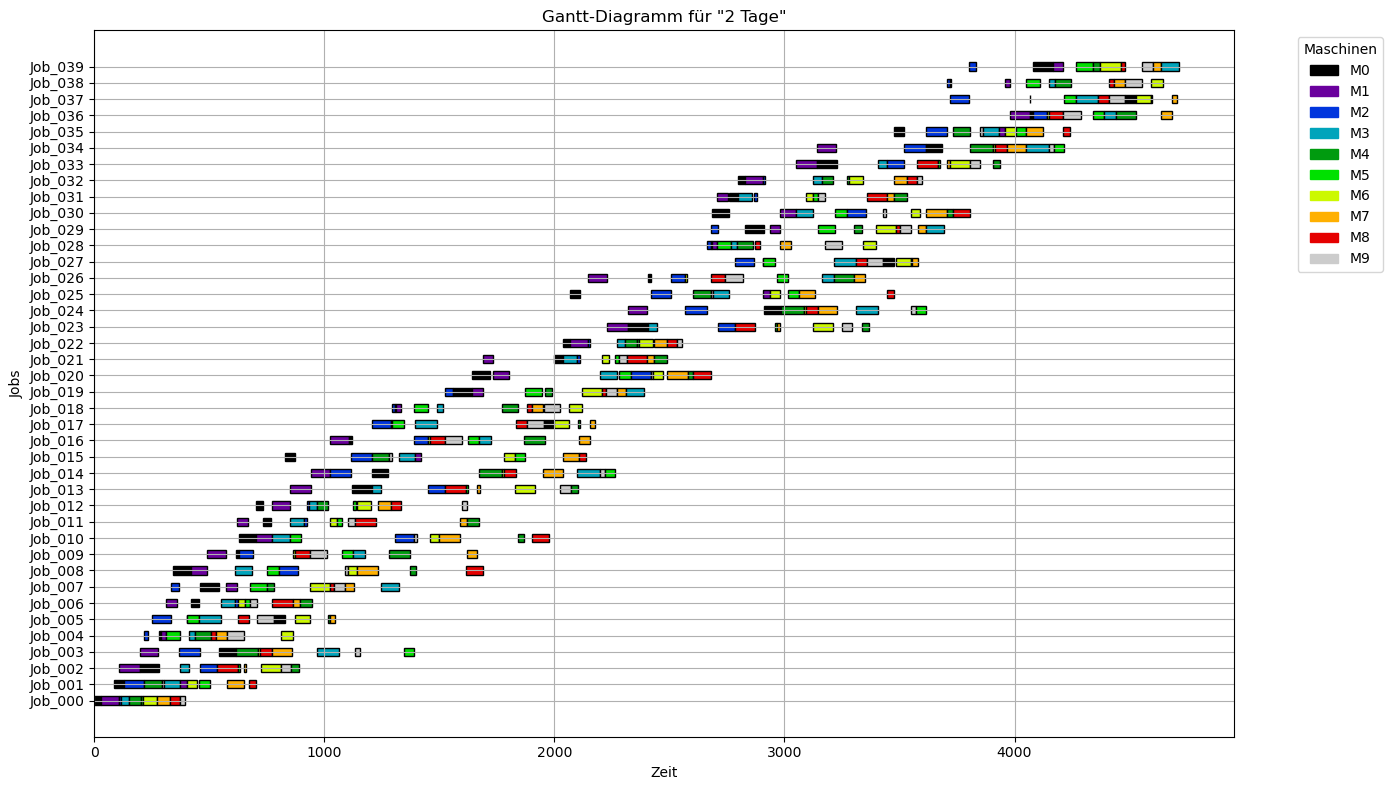

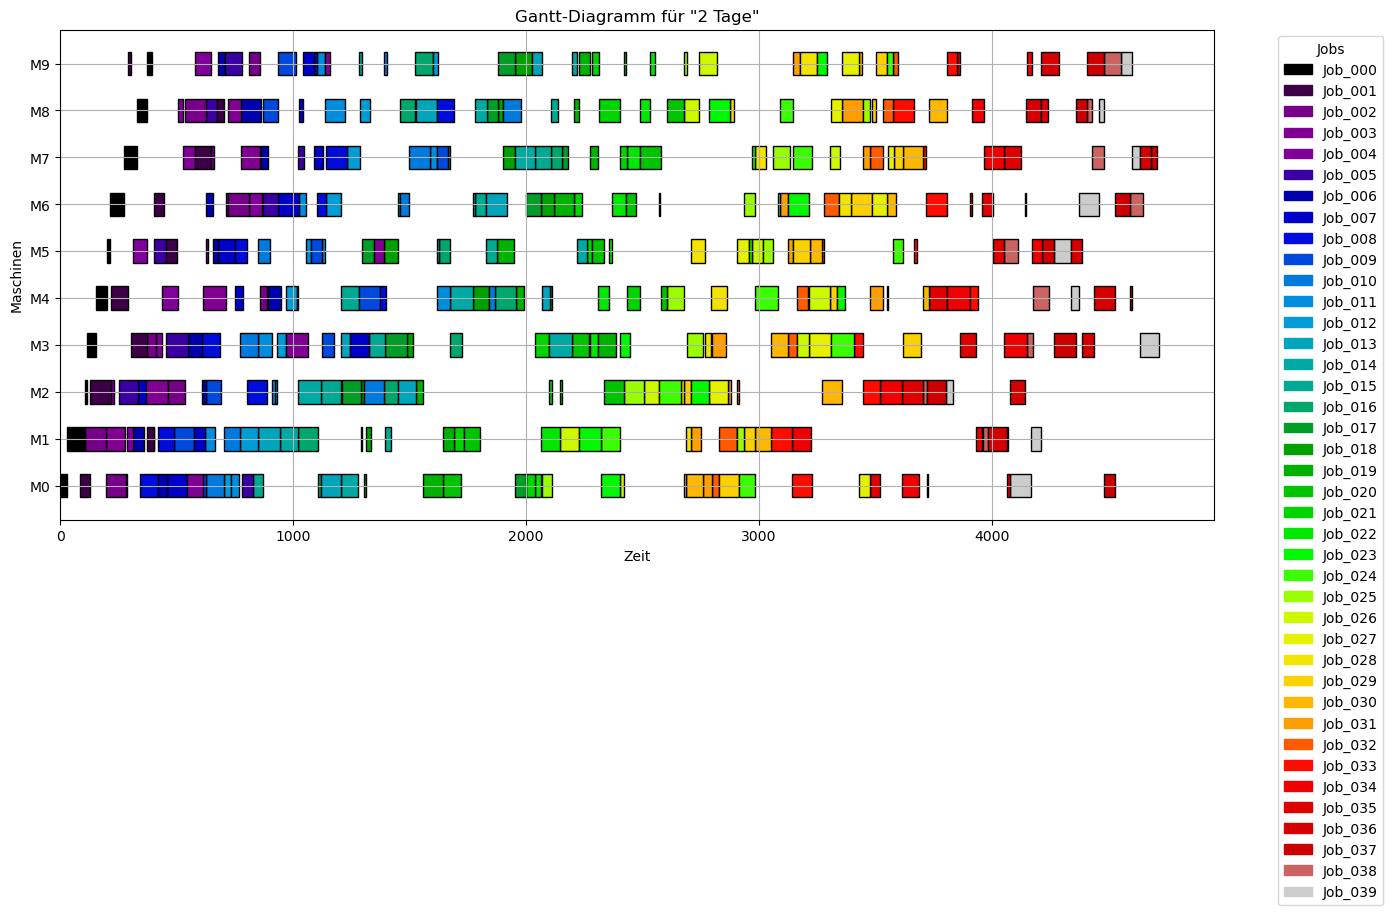

True

In [45]:
category = "2 Tage"

show.plot_gantt_jobs(df_plan, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")
show.plot_gantt_machines(df_plan, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")

is_machine_conflict_free(df_plan)
is_job_machine_sequence_correct(df_plan, jssp_data)
is_start_correct(df_plan, df_arrivals)

In [49]:
df_job_flow = (
    df_plan.groupby("Job")
    .agg({
        "Arrival": "first",
        "Start": "min",
        "End": "max"
    })
    .rename(columns={
        "Arrival": "Arrival Time",
        "Start": "Start",
        "End": "Completion Time"
    })
    .reset_index()
)
df_job_flow 

,Job,Arrival Time,Start,Completion Time
0,Job_000,0.00,0.00,395.00
1,Job_001,84.93,84.93,703.67
2,Job_002,106.18,107.06,889.54
3,Job_003,148.31,198.12,1388.96
4,Job_004,185.08,217.99,864.60
5,Job_005,251.37,251.37,1047.78
6,Job_006,312.71,312.71,948.54
7,Job_007,329.63,335.43,1323.96
8,Job_008,344.30,344.30,1690.20
9,Job_009,429.20,489.36,1663.26


In [ ]:
-

#### ungewichtet

In [54]:
def solve_jssp_total_flowtime(job_dict, df_arrivals, solver_time_limit=300, epsilon=0.00):
    """
    Minimiert die Summe der individuellen Durchlaufzeiten (Flow Times) aller Jobs.
    Zielfunktion: sum_j [ Endzeit_j - Ankunftszeit_j ]

    Parameter:
    - job_dict: Dictionary mit Jobdaten (jede Operation als (Maschine, Dauer))
    - df_arrivals: DataFrame mit Spalten "Job-ID" und "Ankunftszeit (Minuten)"
    - solver_time_limit: Max. Zeit in Sekunden für den Solver
    - epsilon: Kleiner Abstand zur Vermeidung von Maschinenkonflikten
    """

    # Ankunftszeiten und Jobnamen (z. B. in absteigender Ankunftszeit)
    df_arrivals = df_arrivals.sort_values("Ankunftszeit (Minuten)").reset_index(drop=True)
    arrival_times = df_arrivals.set_index("Job-ID")["Ankunftszeit (Minuten)"].to_dict()
    job_names = list(df_arrivals.sort_values("Ankunftszeit (Minuten)", ascending=False)["Job-ID"])

    num_jobs = len(job_names)
    all_ops = [job_dict[job] for job in job_names]
    all_machines = {op[0] for job in all_ops for op in job}

    # LP-Problem
    prob = pulp.LpProblem("JobShop_Total_FlowTime", pulp.LpMinimize)

    # Variablen
    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0, cat="Continuous")
        for j in range(num_jobs) for o in range(len(all_ops[j]))
    }

    job_ends = {
        j: pulp.LpVariable(f"job_end_{j}", lowBound=0, cat="Continuous")
        for j in range(num_jobs)
    }

    # Zielfunktion: ungeeichtete Summe aller Flow Times
    prob += pulp.lpSum([
        job_ends[j] - arrival_times[job_names[j]]
        for j in range(num_jobs)
    ])

    # Technologische Reihenfolge & Ankunftszeit
    for j, job_name in enumerate(job_names):
        job = job_dict[job_name]
        prob += starts[(j, 0)] >= arrival_times[job_name]
        for o in range(1, len(job)):
            d_prev = job[o - 1][1]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + d_prev

    # Maschinenkonflikte (Disjunktivität)
    bigM = 1e5
    for m in all_machines:
        ops = [(j, o, d) for j in range(num_jobs)
               for o, (mach, d) in enumerate(all_ops[j]) if mach == m]
        for i in range(len(ops)):
            j1, o1, d1 = ops[i]
            for j2, o2, d2 in ops[i + 1:]:
                if j1 != j2:
                    y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                    prob += starts[(j1, o1)] + d1 + epsilon <= starts[(j2, o2)] + bigM * (1 - y)
                    prob += starts[(j2, o2)] + d2 + epsilon <= starts[(j1, o1)] + bigM * y

    # Endzeit jeder Job = Ende letzter Operation
    for j in range(num_jobs):
        last_op = len(all_ops[j]) - 1
        prob += job_ends[j] >= starts[(j, last_op)] + all_ops[j][last_op][1]

    # Solver starten
    solver = pulp.HiGHS_CMD(msg=True, timeLimit=solver_time_limit)
    prob.solve(solver)

    # Zeitplan extrahieren
    schedule_data = []
    for (j, o), var in sorted(starts.items()):
        start = var.varValue
        if start is not None:
            machine, duration = all_ops[j][o]
            end = start + duration
            schedule_data.append({
                "Job": job_names[j],
                "Machine": f"M{machine}",
                "Start": round(start, 2),
                "Processing Time": duration,
                "End": round(end, 2)
            })

    df_schedule = pd.DataFrame(schedule_data)
    df_schedule["Arrival"] = df_schedule["Job"].map(arrival_times)
    df_schedule["Flow time"] = df_schedule["End"] - df_schedule["Arrival"]

    df_schedule = df_schedule[["Job", "Arrival", "Machine", "Start", "Processing Time", "Flow time", "End"]]

    total_flowtime = round(pulp.value(prob.objective), 3)
    return df_schedule, total_flowtime


In [62]:
df_plan, total = solve_jssp_total_flowtime(jssp_data, df_arrivals, solver_time_limit=600, epsilon=0.06)

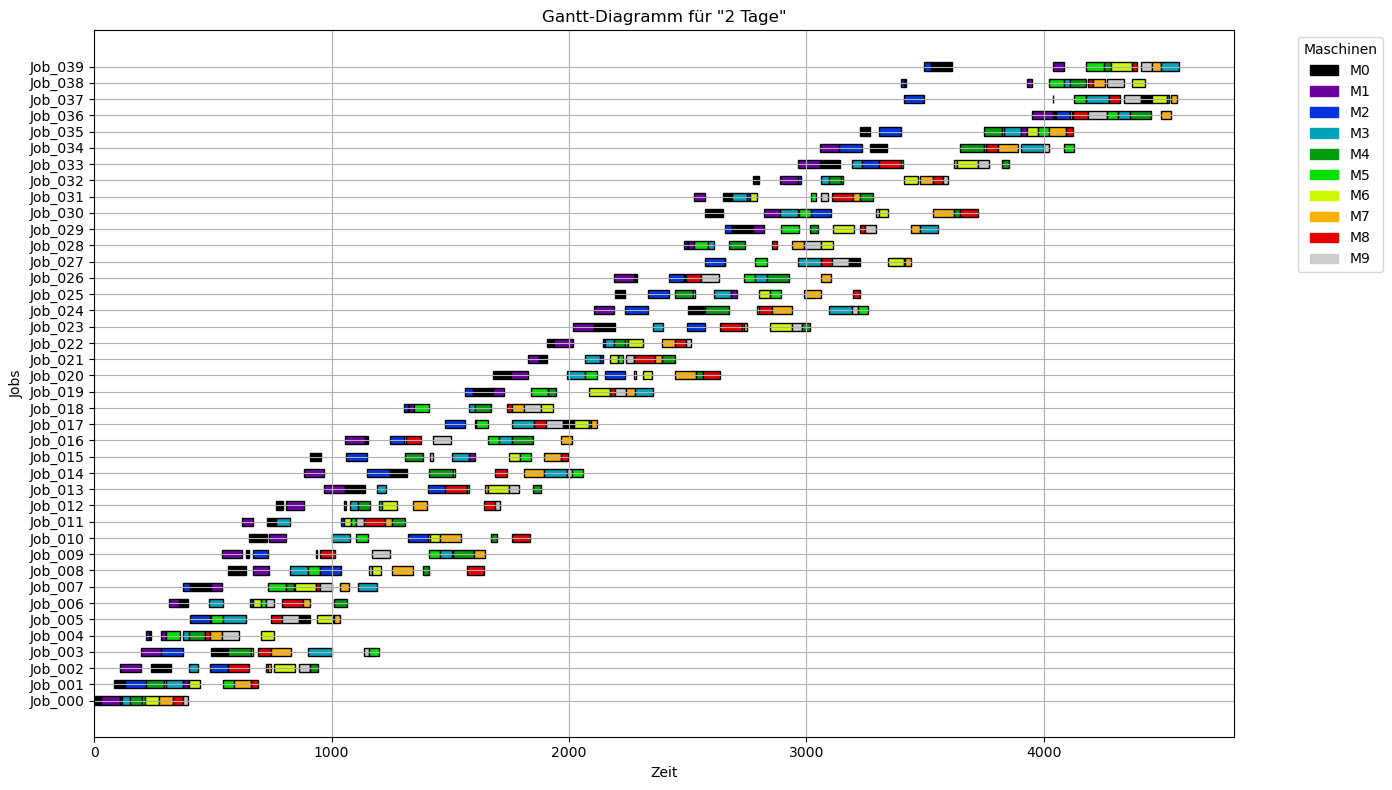

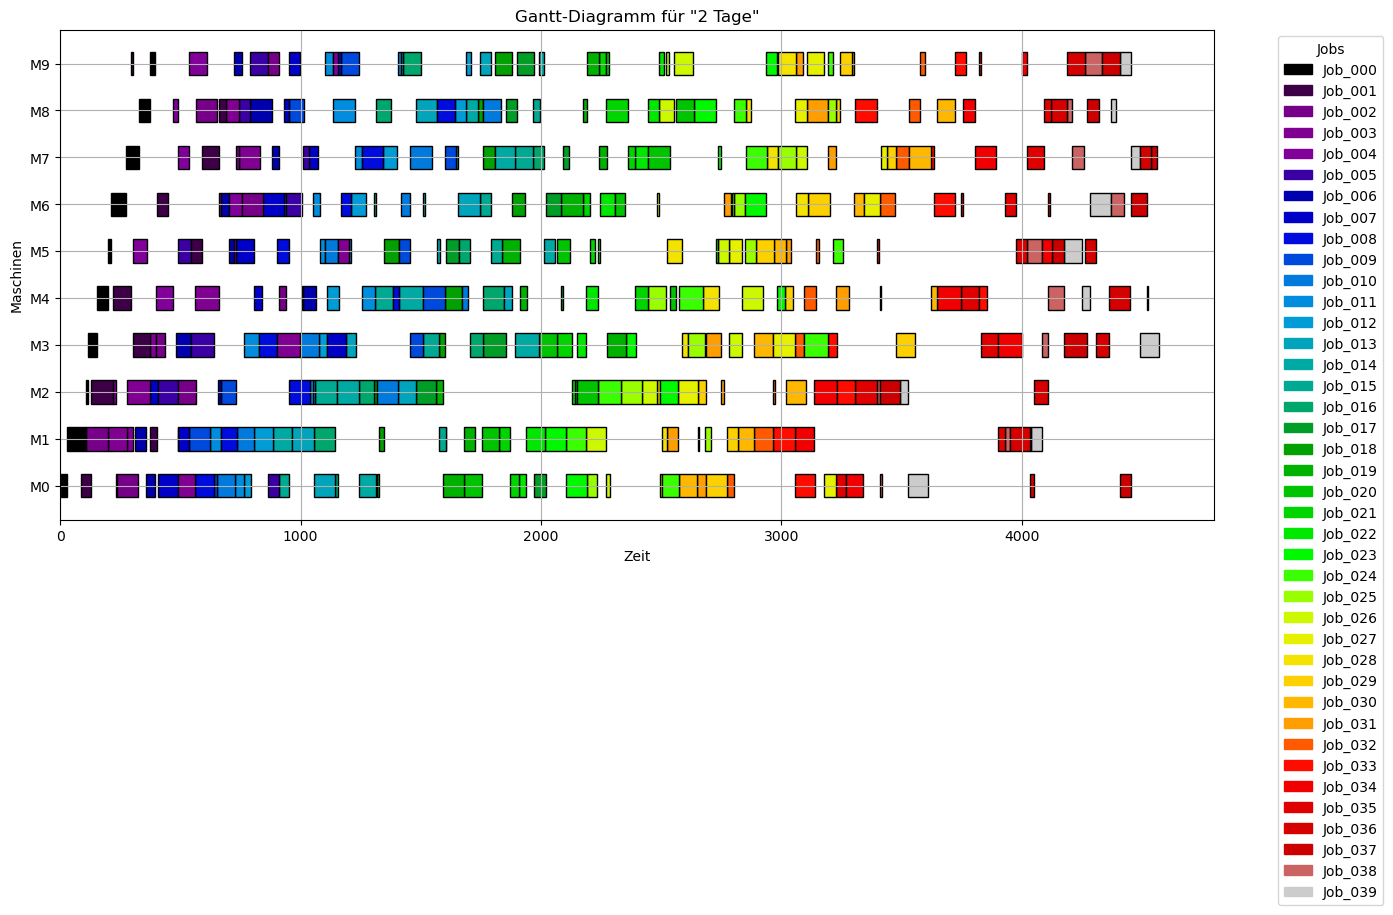

True

In [68]:
category = "2 Tage"

show.plot_gantt_jobs(df_plan, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")
show.plot_gantt_machines(df_plan, 'Gantt-Diagramm für "{}"'.format(category), duration_column = "Processing Time")

is_machine_conflict_free(df_plan)
is_job_machine_sequence_correct(df_plan, jssp_data)
is_start_correct(df_plan, df_arrivals)

In [69]:
df_job_flow2 = (
    df_plan.groupby("Job")
    .agg({
        "Arrival": "first",
        "Start": "min",
        "End": "max"
    })
    .rename(columns={
        "Arrival": "Arrival Time",
        "Start": "Start",
        "End": "Completion Time"
    })
    .reset_index()
)
df_job_flow2

,Job,Arrival Time,Start,Completion Time
0,Job_000,0.00,0.00,395.00
1,Job_001,84.93,84.93,691.30
2,Job_002,106.18,107.06,941.48
3,Job_003,148.31,198.12,1200.66
4,Job_004,185.08,217.99,755.36
5,Job_005,251.37,405.24,1035.60
6,Job_006,312.71,312.71,1065.66
7,Job_007,329.63,374.18,1190.78
8,Job_008,344.30,562.30,1643.08
9,Job_009,429.20,537.36,1644.84
